<a href="https://colab.research.google.com/github/AbhishekGiri1617/Portfolio-Management-using-DRL-TD3/blob/main/TD3VST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
from collections import deque
import random
from scipy import stats
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as plt

class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (torch.FloatTensor(state),
                torch.FloatTensor(action),
                torch.FloatTensor(reward),
                torch.FloatTensor(next_state),
                torch.FloatTensor(done))

    def __len__(self):
        return len(self.buffer)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.layer_1 = nn.Linear(state_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, state):
        a = torch.relu(self.layer_1(state))
        a = torch.relu(self.layer_2(a))
        return self.max_action * torch.tanh(self.layer_3(a))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.layer_1 = nn.Linear(state_dim + action_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)

        # Q2 architecture
        self.layer_4 = nn.Linear(state_dim + action_dim, 400)
        self.layer_5 = nn.Linear(400, 300)
        self.layer_6 = nn.Linear(300, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = torch.relu(self.layer_1(sa))
        q1 = torch.relu(self.layer_2(q1))
        q1 = self.layer_3(q1)

        q2 = torch.relu(self.layer_4(sa))
        q2 = torch.relu(self.layer_5(q2))
        q2 = self.layer_6(q2)

        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = torch.relu(self.layer_1(sa))
        q1 = torch.relu(self.layer_2(q1))
        q1 = self.layer_3(q1)

        return q1

class TD3:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters())

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters())

        self.max_action = max_action

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1))
        return self.actor(state).data.numpy().flatten()

    def train(self, replay_buffer, iterations, batch_size=100, discount=0.99,
             tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

        for it in range(iterations):
            # Sample a batch from replay buffer
            state, action, reward, next_state, done = replay_buffer.sample(batch_size)

            # Select action according to policy and add clipped noise
            noise = torch.randn_like(action) * policy_noise
            noise = noise.clamp(-noise_clip, noise_clip)

            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (1 - done) * discount * target_Q

            # Get current Q estimates
            current_Q1, current_Q2 = self.critic(state, action)

            # Compute critic loss
            critic_loss = nn.MSELoss()(current_Q1, target_Q) + nn.MSELoss()(current_Q2, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Delayed policy updates
            if it % policy_freq == 0:
                # Compute actor loss
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update the frozen target models
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

# class TradingEnvironment:
#     def __init__(self, data, initial_balance=10000, transaction_fee=0.001):
#         self.data = data
#         self.initial_balance = initial_balance
#         self.transaction_fee = transaction_fee
#         self.reset()

#     def reset(self):
#         self.current_step = 0
#         self.balance = self.initial_balance
#         self.shares_held = 0
#         self.asset_value = 0
#         self.total_value = self.balance

#         return self._get_observation()

#     def _get_observation(self):
#         # Use past 10 days of price data and current portfolio state
#         obs = np.array(self.data[self.current_step:self.current_step+10]['Close'])
#         #Reshape obs to have the same number of dimensions as portfolio_state
#         obs = obs.reshape(-1)
#         portfolio_state = np.array([self.balance, self.shares_held, self.asset_value, self.total_value])
#         return np.concatenate([obs, portfolio_state])
#         # # Use past 10 days of price data and current portfolio state
#         # obs = np.array(self.data[self.current_step:self.current_step+10]['Close'])
#         # portfolio_state = np.array([self.balance, self.shares_held, self.asset_value, self.total_value])
#         # return np.concatenate([obs, portfolio_state])

#     def step(self, action):
#         current_price = self.data.iloc[self.current_step]['Close']

#         # Action is the percentage of portfolio to allocate to the asset
#         target_asset_value = self.total_value * action[0]
#         current_asset_value = self.shares_held * current_price

#         # Calculate the trade required
#         trade_value = target_asset_value - current_asset_value

#         if trade_value > 0:  # Buying
#             shares_to_buy = trade_value / current_price
#             transaction_cost = trade_value * self.transaction_fee
#             if self.balance >= (trade_value + transaction_cost):
#                 self.shares_held += shares_to_buy
#                 self.balance -= (trade_value + transaction_cost)

#         elif trade_value < 0:  # Selling
#             shares_to_sell = -trade_value / current_price
#             if self.shares_held >= shares_to_sell:
#                 transaction_cost = -trade_value * self.transaction_fee
#                 self.shares_held -= shares_to_sell
#                 self.balance += (-trade_value - transaction_cost)

#         # Move to next step
#         self.current_step += 1

#         # Calculate reward (daily return)
#         self.asset_value = self.shares_held * current_price
#         new_total_value = self.balance + self.asset_value
#         reward = (new_total_value - self.total_value) / self.total_value
#         self.total_value = new_total_value

#         # Check if episode is done
#         done = self.current_step >= len(self.data) - 11

#         obs = self._get_observation()
#         return obs, reward, done, {}

class TradingEnvironment:
    def __init__(self, data, initial_balance=10000, transaction_fee=0.001):
        self.data = data
        self.initial_balance = initial_balance
        self.transaction_fee = transaction_fee
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.asset_value = 0
        self.total_value = self.balance

        return self._get_observation()

    def _get_observation(self):
        # Use past 10 days of price data and current portfolio state
        obs = np.array(self.data[self.current_step:self.current_step+10]['Close'])
        #Reshape obs to have the same number of dimensions as portfolio_state
        obs = obs.reshape(-1)
        # Ensure portfolio state variables are numerical
        portfolio_state = np.array([
            float(self.balance),
            float(self.shares_held),
            float(self.asset_value),
            float(self.total_value)
        ])
        return np.concatenate([obs, portfolio_state])
        # # Use past 10 days of price data and current portfolio state
        # obs = np.array(self.data[self.current_step:self.current_step+10]['Close'])
        # portfolio_state = np.array([self.balance, self.shares_held, self.asset_value, self.total_value])
        # return np.concatenate([obs, portfolio_state])

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']

        if isinstance(current_price, pd.Series):
            current_price = current_price.item()

        # Action is the percentage of portfolio to allocate to the asset
        target_asset_value = float(self.total_value * action[0])  # Ensure float
        current_asset_value = float(self.shares_held * current_price)  # Ensure float

        # Calculate the trade required
        trade_value = target_asset_value - current_asset_value

        # Explicitly use numpy for comparison
        if np.greater(trade_value, 0):  # Buying
            shares_to_buy = trade_value / current_price
            transaction_cost = trade_value * self.transaction_fee
            if self.balance >= (trade_value + transaction_cost):
                self.shares_held += shares_to_buy
                self.balance -= (trade_value + transaction_cost)

        elif np.less(trade_value, 0):  # Selling
            shares_to_sell = -trade_value / current_price
            if self.shares_held >= shares_to_sell:
                transaction_cost = -trade_value * self.transaction_fee
                self.shares_held -= shares_to_sell
                self.balance += (-trade_value - transaction_cost)
        # Move to next step
        self.current_step += 1

        # print(f"type of self.total_value: {type(self.total_value)}")

        # Calculate reward (daily return)
        self.asset_value = self.shares_held * current_price
        new_total_value = self.balance + self.asset_value
        reward = (new_total_value - self.total_value) / self.total_value
        self.total_value = float(new_total_value)

        # Check if episode is done
        done = self.current_step >= len(self.data) - 11

        obs = self._get_observation()
        return obs, reward, done, {}


def train_td3_agent():
    # Download stock data
    stock_data = yf.download('AAPL', start='2010-01-01', end='2023-12-31')

    # Split data into train and test
    train_data = stock_data['2010-01-01':'2022-12-31']
    test_data = stock_data['2023-01-01':]

    # Initialize environment
    env = TradingEnvironment(train_data)

    state_dim = 14  # 10 days of prices + 4 portfolio state variables
    action_dim = 1  # Percentage of portfolio to allocate to asset
    max_action = 1  # Maximum allocation is 100%

    # Initialize TD3 agent
    agent = TD3(state_dim, action_dim, max_action)
    replay_buffer = ReplayBuffer()

    # Training parameters
    epochs = 3
    steps_per_epoch = 1000
    batch_size = 256

    # Training loop
    for epoch in range(epochs):
        state = env.reset()
        episode_reward = 0

        for step in range(steps_per_epoch):
            # Select action
            action = agent.select_action(state)
            action = np.clip(action + np.random.normal(0, 0.1), 0, 1)

            # Take action in environment
            next_state, reward, done, _ = env.step(action)

            # Store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward
            episode_reward += float(reward)

            # Train agent
            if len(replay_buffer) > batch_size:
                agent.train(replay_buffer, 10, batch_size)

            if done:
                break
        total_value = float(env.total_value)
        print(f"Epoch {epoch+1}/{epochs}, Reward: {episode_reward:.2f}, Final Value: ${env.total_value:.2f}")

    return agent, env

if __name__ == "__main__":
    agent, env = train_td3_agent()

[*********************100%***********************]  1 of 1 completed
<ipython-input-1-cc182c9e211e>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return (torch.FloatTensor(state),
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/3, Reward: 0.00, Final Value: $10000.00
Epoch 2/3, Reward: 0.00, Final Value: $10000.00
Epoch 3/3, Reward: 0.00, Final Value: $10000.00


In [ ]:
# Define the visualizer class
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import yfinance as yf
from typing import List, Tuple
from IPython.display import display, HTML

class ColabTradingVisualizer:
    def __init__(self):
        """Initialize the visualizer"""
        plt.style.use('seaborn')
        self.performance_history = []
        self.action_history = []
        self.portfolio_history = []

    def evaluate_agent(self, agent, test_start='2023-01-01', test_end='2024-08-31', symbol='TCS'):
        """Evaluate the trained agent on test data"""
        # Get test data
        test_data = yf.download(symbol, start=test_start, end=test_end)

        # Create new environment for testing
        env = TradingEnvironment(test_data)
        state = env.reset()
        done = False

        print("Running evaluation on test data...")

        while not done:
            # Get action from agent
            action = agent.select_action(state)

            # Record state before step
            self.portfolio_history.append({
                'balance': float(env.balance),
                'shares_held': float(env.shares_held),
                'asset_value': float(env.asset_value),
                'total_value': float(env.total_value),
                'price': float(test_data.iloc[env.current_step]['Close'])
            })

            # Take action
            next_state, reward, done, _ = env.step(action)

            # Record action and performance
            self.action_history.append(float(action[0]))
            self.performance_history.append(float(reward))

            state = next_state

        print("Evaluation complete. Generating visualizations...")
        return test_data

    def plot_results(self, initial_balance=10000):
        """Plot all results"""
        # Convert data to DataFrame for easier plotting
        portfolio_df = pd.DataFrame(self.portfolio_history)

        # Create subplots
        fig = plt.figure(figsize=(20, 15))

        # 1. Portfolio Value Plot
        ax1 = plt.subplot(311)
        portfolio_df['total_value'].plot(label='Portfolio Value', ax=ax1)
        initial_shares = initial_balance / portfolio_df['price'].iloc[0]
        buy_hold_value = initial_shares * portfolio_df['price']
        buy_hold_value.plot(label='Buy & Hold', style='--', ax=ax1)
        ax1.set_title('Portfolio Value vs Buy & Hold')
        ax1.set_ylabel('Value ($)')
        ax1.legend()
        ax1.grid(True)

        # 2. Trading Actions Plot
        ax2 = plt.subplot(312)
        ax2.plot(portfolio_df['price'], label='Stock Price')
        ax2_twin = ax2.twinx()
        ax2_twin.plot(self.action_history, label='Action', color='red', alpha=0.5)
        ax2.set_title('Stock Price and Trading Actions')
        ax2.set_ylabel('Price ($)')
        ax2_twin.set_ylabel('Action')
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2_twin.legend(lines1 + lines2, labels1 + labels2)
        ax2.grid(True)

        # 3. Returns Distribution
        ax3 = plt.subplot(313)
        returns = pd.Series(self.performance_history)
        sns.histplot(returns, kde=True, ax=ax3)
        ax3.set_title('Distribution of Returns')
        ax3.set_xlabel('Return')
        ax3.grid(True)

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        total_return = (portfolio_df['total_value'].iloc[-1] / initial_balance - 1) * 100
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
        max_drawdown = np.min(portfolio_df['total_value'] / portfolio_df['total_value'].cummax() - 1) * 100

        print("\n=== Performance Summary ===")
        print(f"Total Return: {total_return:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print(f"Win Rate: {(returns > 0).mean() * 100:.2f}%")
        print(f"Average Daily Return: {np.mean(returns) * 100:.2f}%")
        print(f"Return Volatility: {np.std(returns) * 100:.2f}%")

<ipython-input-10-d0de6ee13e75>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
[*********************100%***********************]  1 of 1 completed
<ipython-input-10-d0de6ee13e75>:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'price': float(test_data.iloc[env.current_step]['Close'])


Running evaluation on test data...
Evaluation complete. Generating visualizations...


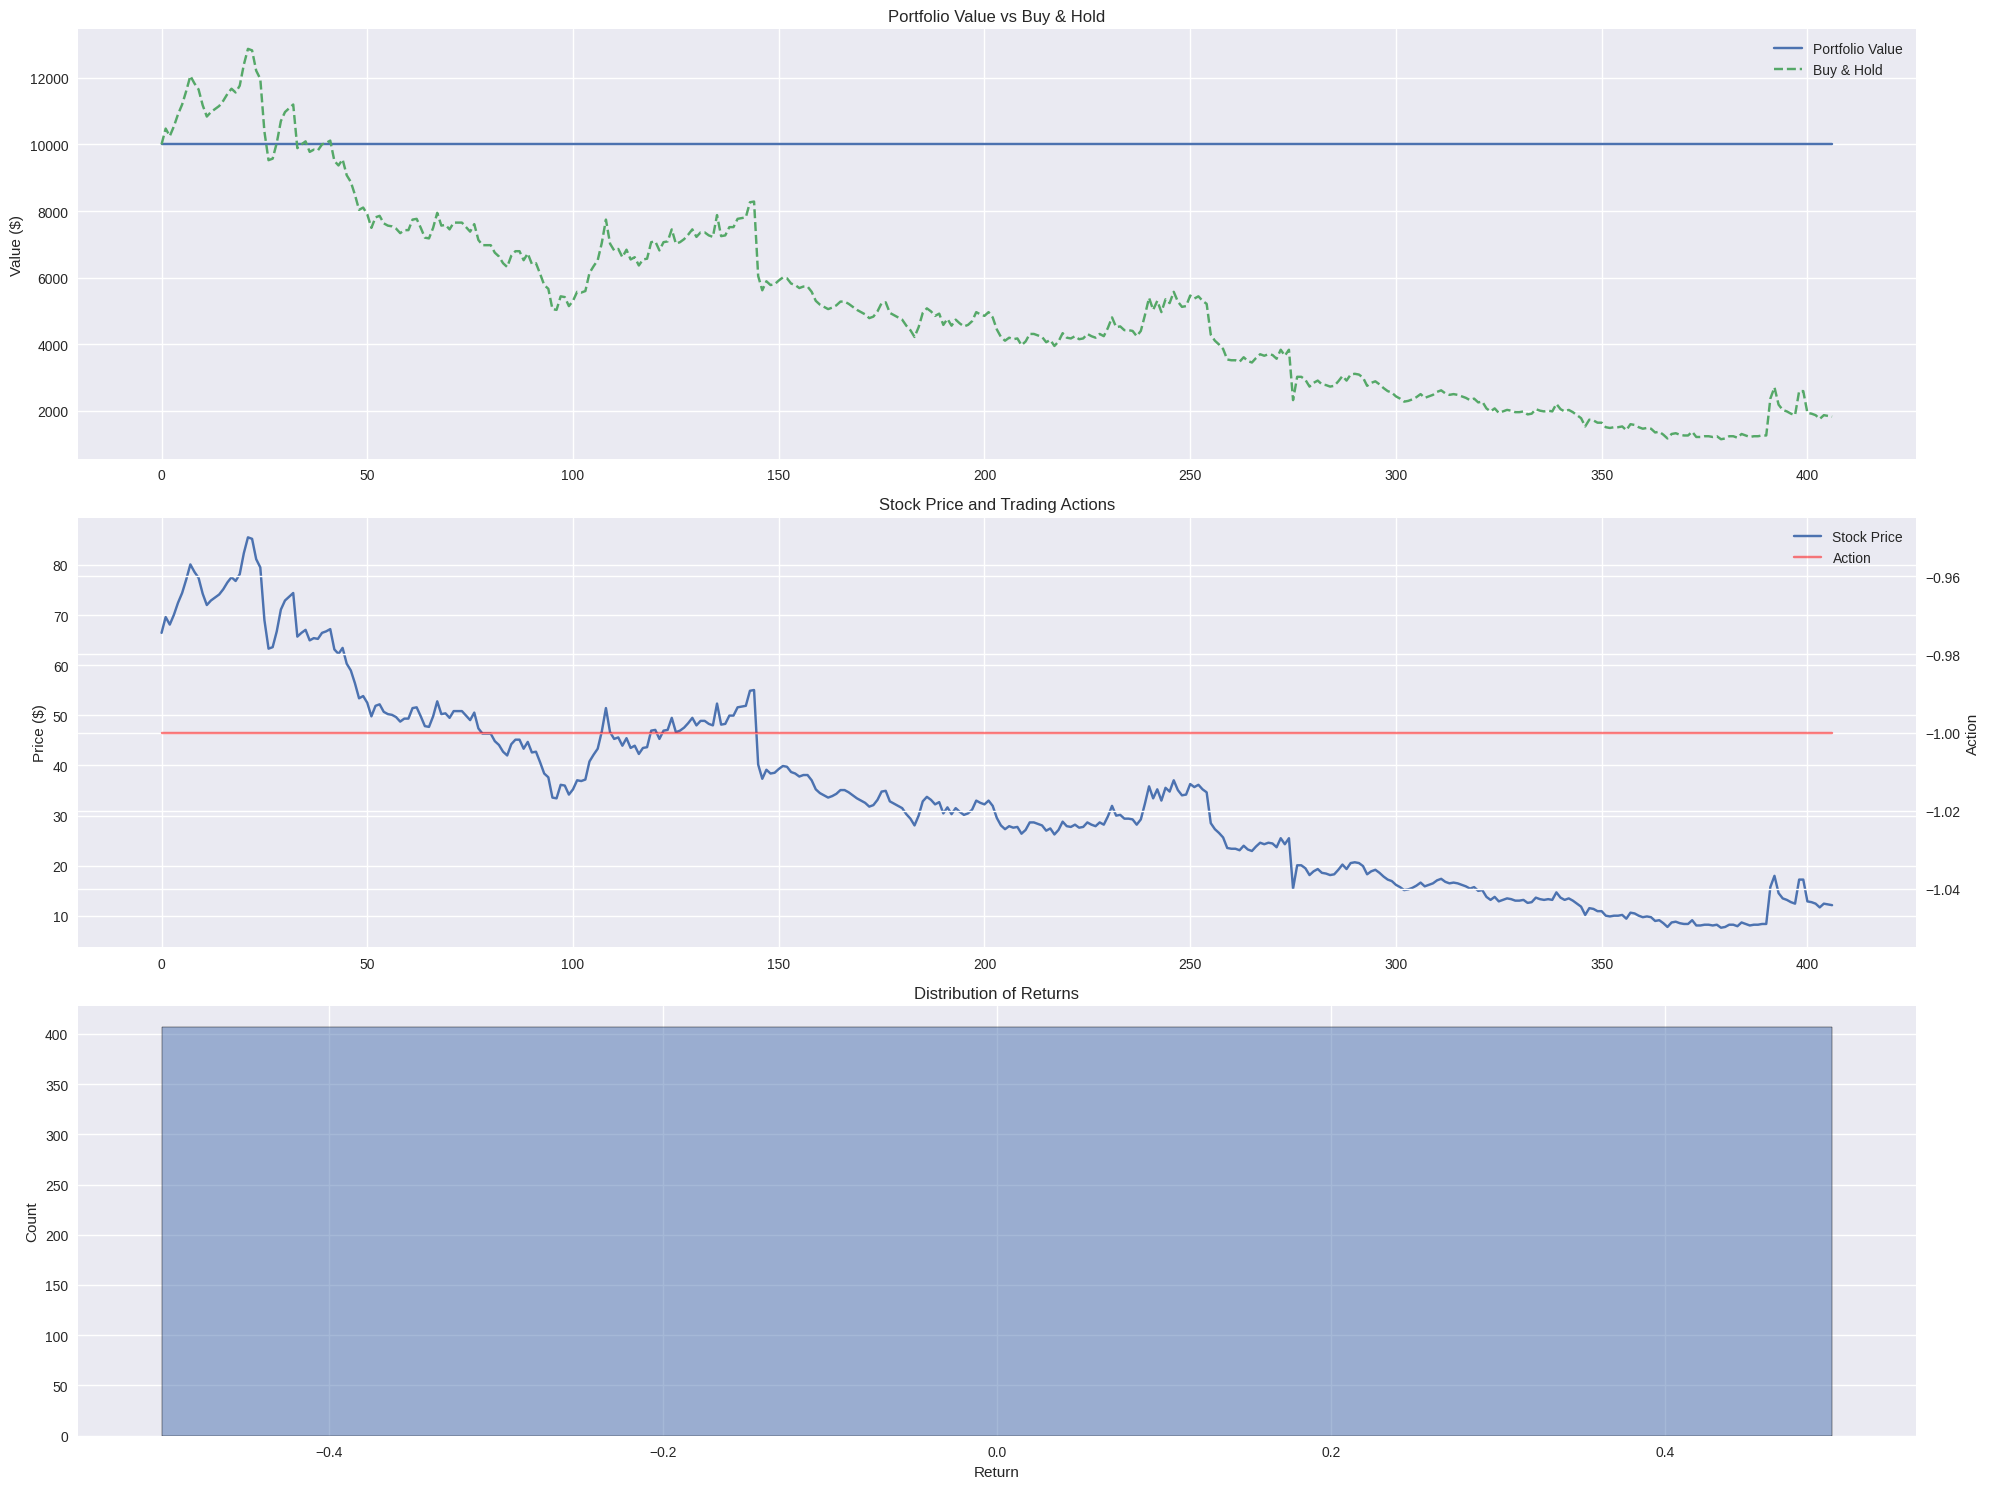


=== Performance Summary ===
Total Return: 0.00%
Sharpe Ratio: nan
Max Drawdown: 0.00%
Win Rate: 0.00%
Average Daily Return: 0.00%
Return Volatility: 0.00%


<ipython-input-10-d0de6ee13e75>:101: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)


In [ ]:
# Create visualizer and generate plots
visualizer = ColabTradingVisualizer()
test_data = visualizer.evaluate_agent(agent)  # Uses your trained agent
visualizer.plot_results()